# Boosting algorithm

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
from math import log, exp

In [13]:
seed = 42

### Load data

In [14]:
# load and prepare data
data = np.loadtxt('sonar.all-data', delimiter=',', dtype=np.str_)
X = data[:, :-1].astype(np.float_)
y = (data[:, -1] == "M").astype(np.int_)
y = np.where(y == 0, -1, 1)

print(f"Number of samples:  {X.shape[0]}")
print(f"Number of features: {X.shape[-1]}")

Number of samples:  208
Number of features: 60


In [15]:
# split for cross-vall and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

kf = KFold(n_splits=5, shuffle=True, random_state=seed)

### Boosting train and predict functions


**Note 1**: 

in scikit-learn, all supervised estimators implement a ``fit(X, y)`` method and a ``predict(X)`` method with ``X`` being unlabeled observations and  ``y`` being labels. 

Therefore ``Classifier`` parameter can be any sklearn class implementing a supervised classifier.

(See *The problem solved in supervised learning* section in the supervised learning tutorial from [sklearn documentation](https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html)

**Note 2**: 

Some sklearn classifiers (such as [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), etc.)  have a ``sample_weight`` parameters in their ``fit`` and ``score`` methods, making it easy to implement a user-defined boosting algorithm. 

In [16]:
def boosting_train(
    X_train, 
    y_train, 
    n_clfs,           # number of classifier
    Classifier,       # Python class of classifier
    clfs_args = {},   # Specific python class of classifier's arguments
):
    """
    Adaboost training lgorithm
    """
    clfs = []
    alphas = []
    # Initialize weights to 1/n
    n = len(y_train)
    w = np.ones(n) / n

    for t in range(n_clfs):
        # -------------------------
        # Train a new classifier
        # -------------------------

        # Train a weak learner using the training data and the sample weights
        clf = Classifier(**clfs_args)
        clf.fit(X_train, y_train, sample_weight=w)
        clfs.append(clf)
        

        # Compute weighted training accuracy
        y_pred = clf.predict(X_train)
        error = np.sum(w * (y_train != y_pred))

        # Compute alpha_t (and avoid math errors)
        alpha = 0.5 * log((1 - error) / max(error, 1e-10))
        alphas.append(alpha)


        # -------------------------
        # Update weights
        # -------------------------
        # Weights increase only if y_train != y_pred 
        # so that we concentrate on “hardest” examples

        w = w * np.exp(-alpha * y_train * y_pred)
        # Normalize weights
        w /= np.sum(w)

    # Return the list of trained classifiers composing the boosting classifier
    # with their corresponding weights 'alphas'
    return(clfs, alphas)

def boosting_predict(
    clfs,       # list of classifiers composing the boosting classifier
    alphas,     # Weights associated with each classifier in 'clfs'
    X,
):
    """
    Adaboost predict algorithm
    """
    n = len(X)
    y_pred = np.zeros(n)
    for clf, alpha in zip(clfs, alphas):
        y_pred += alpha * clf.predict(X)
    return np.sign(y_pred)

In [17]:
class CustomAdaBoost:
    def __init__(self, n_clfs, Classifier, clfs_args={}):
        self.n_clfs = n_clfs
        self.Classifier = Classifier
        self.clfs_args = clfs_args

    def fit(self, X, y):
        self.clfs, self.alphas = boosting_train(X, y, self.n_clfs, self.Classifier, self.clfs_args)

    def predict(self, X):
        return boosting_predict(self.clfs, self.alphas, X)

### Boosting pipeline using cross validation

In [18]:
n_clfs = [1, 10, 50, 100, 200]
args = {"max_depth": 1, "random_state": seed}
best_score = 0
best_model_dt = None
dt_accuracies = []

# Loop over different numbers of classifiers
for n in n_clfs:
    # Create the pipeline with the custom AdaBoost classifier
    pipeline = Pipeline([
        ('boost', CustomAdaBoost(n_clfs=n, Classifier=DecisionTreeClassifier, clfs_args=args))
    ])
    
    # Perform cross-validation using KFold
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
    mean_score = np.mean(scores)
    print(f"Accuracy for {n} classifiers: {mean_score}")
    
    dt_accuracies.append(mean_score)
    # Update the best model if the current one performs better
    if mean_score > best_score:
        best_score = mean_score
        best_model_dt = pipeline

# Train the best model on the full training data and evaluate on the test set
best_model_dt.fit(X_train, y_train)
y_test_pred = best_model_dt.predict(X_test)
test_accuracy_dt = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy of the best model: {test_accuracy_dt}")


Accuracy for 1 classifiers: 0.7231729055258466
Accuracy for 10 classifiers: 0.73475935828877
Accuracy for 50 classifiers: 0.759536541889483
Accuracy for 100 classifiers: 0.7953654188948308
Accuracy for 200 classifiers: 0.7832442067736187
Test accuracy of the best model: 0.8333333333333334


### Training different boosting models on the sonar dataset

In [19]:
n_clfs = [1, 10, 50, 100, 200]
args = {"random_state": seed}
best_score = 0
best_model_lr = None
lt_accuracies = []


# Loop over different numbers of classifiers
for n in n_clfs:
    # Create the pipeline with the custom AdaBoost classifier
    pipeline = Pipeline([
        ('boost', CustomAdaBoost(n_clfs=n, Classifier=LogisticRegression, clfs_args=args))
    ])
    
    # Perform cross-validation using KFold
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
    mean_score = np.mean(scores)
    print(f"Accuracy for {n} classifiers: {mean_score}")
    
    lt_accuracies.append(mean_score)

    # Update the best model if the current one performs better
    if mean_score > best_score:
        best_score = mean_score
        best_model_lr = pipeline

# Train the best model on the full training data and evaluate on the test set
best_model_lr.fit(X_train, y_train)
y_test_pred = best_model_lr.predict(X_test)
test_accuracy_lr = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy of the best model: {test_accuracy_lr}")

Accuracy for 1 classifiers: 0.4878787878787879
Accuracy for 10 classifiers: 0.7169340463458109
Accuracy for 50 classifiers: 0.7472370766488414
Accuracy for 100 classifiers: 0.7233511586452763
Accuracy for 200 classifiers: 0.7233511586452763
Test accuracy of the best model: 0.7380952380952381


### Selecting and evaluating the best boosting model

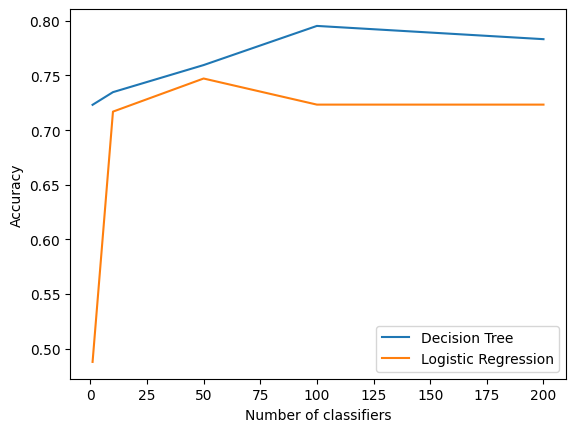

In [20]:
# plot accuracy
plt.plot(n_clfs, dt_accuracies, label="Decision Tree")
plt.plot(n_clfs, lt_accuracies, label="Logistic Regression")
plt.xlabel("Number of classifiers")
plt.ylabel("Accuracy")

plt.legend()
plt.show()